In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
dimensions = 2**np.arange(6,13)

In [10]:
def DFT(image): # Descrete Fourier Transform over the first axis
    assert image.dtype == np.complex64
    h, w = image.shape
    ret = np.empty_like(image, dtype = 'complex64') # int32_t real, int32_t imag
    yi, xi = np.indices((h, h), dtype = 'complex64')
    matrix = np.exp(yi*xi*(np.pi * -2j / h))
    return matrix@image
def DFT_2D(image): # DFT over both axes, consequentially
    return DFT(DFT(image).T).T


In [11]:
from functools import lru_cache
def FFT(image): # Cooley - Tukey Divde and Conquer. Top-Down Approach.
    assert image.dtype == np.complex64
    out = image.copy()
    @lru_cache(None)
    def get_vector(h):
        return np.exp(np.indices((h//2,), dtype = 'complex64') * (np.pi * -2j / h)).reshape(-1,1)
    def FFT_half_sample(out):
        h, w = out.shape
        if h == 1:return
        assert h%2 == 0
        FFT_half_sample(out[::2]) # EVEN
        FFT_half_sample(out[1::2]) # ODD
        vector = get_vector(h)
        out[:h//2], out[h//2:] = out[::2] + vector * out[1::2], out[::2] - vector * out[1::2]
    FFT_half_sample(out)
    return out
def FFT_2D(image):
    return FFT(FFT(image).T).T

In [12]:
def flip_scale(image):
    image[1:,:] = image[-1:0:-1,:]
    image[:,1:] = image[:,-1:0:-1]
    image /= image.size

In [13]:
def convolve_DFT(image1, image2):
    Fourier = DFT_2D(image1) * DFT_2D(image2)
    ret = DFT_2D(Fourier)
    flip_scale(ret)
    return ret
def convolve_FFT(image1, image2):
    Fourier = FFT_2D(image1) * FFT_2D(image2)
    ret = FFT_2D(Fourier)
    flip_scale(ret)
    return ret

In [14]:
def convolve(image1, image2):
    h, w = image1.shape
    padded = np.tile(image1,(2,2))
    ret = np.empty_like(image1)
    for y,row in enumerate(ret):
        for x,c in enumerate(row):
            ret[y,x] = (padded[y:y+h,x:x+h]*image2[::-1,::-1]).sum()
    return ret

In [15]:
Convolve_time = []
DFT_time = []
FFT_time = []
for i,dimension in enumerate(dimensions):
    img1 = np.random.random((dimension, dimension)).astype('complex64')
    img2 = np.random.random((dimension, dimension)).astype('complex64')
    t = time()
    if i<3:
        convolve(img1,img2) # O(d^4)!!
        Convolve_time.append(time()-t)
        t = time()
    convolve_DFT(img1,img2) # O(d^3)
    DFT_time.append(time()-t)
    t = time()
    convolve_FFT(img1,img2) # O(d^2(log(d)))
    FFT_time.append(time()-t)
    t = time()

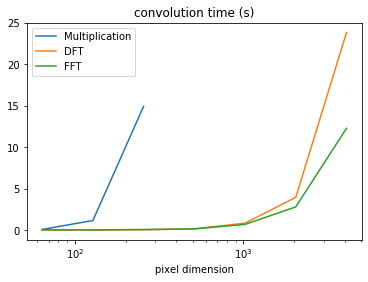

In [445]:
plt.plot(dimensions[:len(Convolve_time)], Convolve_time, label = 'Multiplication')
plt.plot(dimensions, DFT_time, label = 'DFT')
plt.plot(dimensions, FFT_time, label = 'FFT')
plt.xscale('log')
plt.xlabel('pixel dimension')
plt.title('convolution time (s)')
plt.legend()

In [2]:
import pyopencl as cl

In [3]:
ctx = cl.Context(devices=cl.get_platforms()[0].get_devices()[:1])
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
a_np = np.random.random((1024,1024)).astype('c8')
# a_np = np.array([1,2,3,4]).astype('c8')
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
# b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

#complex64 x+yi
#float2 x,y
local_size = (1,min(1024, a_np.shape[1]))
prg = cl.Program(ctx, f"""
#define TPB_Y {local_size[1]}
"""+"""
inline float2 comp_mul(float2 a, float2 b){
  return (float2)(a.x*b.x - a.y*b.y, a.x*b.y + a.y*b.x);
}
// exp(iw) = cosw + sinw*i
inline float2 comp_exp(float2 a){
  return (float2)(exp(a.x)) * (float2)(cos(a.y), sin(a.y));
}
inline float2 exp_i(float a){
  return (float2)(cos(a), sin(a));
}
__kernel void DFT(__global const float2 *A, __global float2 *B){ // 1D over 1D
  const int n = get_global_size(1);
  const int By = get_global_id(1);
  const int ty = get_local_id(1);
  const int ly = get_global_size(0);
  const int row = get_global_id(0);
  __private float2 sum = (0, 0);
  __local float2 shared[TPB_Y];
  // without shared memory : (n global reads) + (1 global writes) per thread
  // with shared memory : (n/TPB global reads) + (n/TPB global writes) per thread
  for(int Ay = 0; Ay < n; Ay += TPB_Y){
    if(Ay+ty<n)shared[ty] = A[n*row + Ay + ty];
    barrier(CLK_LOCAL_MEM_FENCE); // load shared memory and synchronize
    for(int x = Ay; x < Ay + TPB_Y; x++)sum += comp_mul(exp_i(-2*M_PI_F/n*x*By), shared[x-Ay]);
  }
  B[n*row + By] = sum;
}
__kernel void FFT_rearrange(__global const float2 *A, __global float2 *B){ // 1D(X) over 2D(Y,X)
  const int nx = get_global_size(1);
  const int ty = get_global_id(0);
  const int tx = get_global_id(1);
  private int n = nx;
  private int dx = 0, x=tx;
  while(n>1){
    dx <<= 1;
    dx += x%2;
    x>>=1;
    n>>=1;
  }
  B[nx*ty + dx] = A[nx*ty + tx];
}
__kernel void FFT_under_512(__global float2 *A){ // kernel size 1x512, in place
  const int nx = get_global_size(1);
  const int y = get_global_id(0);
  const int x = get_global_id(1);
  const int tx = get_local_id(1);
  __local float2 shared[512]; // 9 recursion, 1 global read, 1 global write
  shared[tx] = A[nx*y + x]; // global read
  barrier(CLK_LOCAL_MEM_FENCE);
  int odd, dx, hx;
  float2 temp;
  for(int i=1;i<=9;i++){
    dx = (tx>>i)<<i;
    odd = tx & ( 1 << (i-1) );
    hx = (tx^dx) & (odd-1);
    temp = shared[dx + hx] + (odd?-1:1) * comp_mul(exp_i(-2*M_PI_F/(1 << i)*hx), shared[dx + (1 << (i-1)) + hx] );
    barrier(CLK_LOCAL_MEM_FENCE);
    shared[tx] = temp;
    barrier(CLK_LOCAL_MEM_FENCE);
  }
  A[nx*y + x] = shared[tx]; // global write
}
__kernel void FFT_over_512(__global const float2 *A, __global float2 *B , const int i){
  const int nx = get_global_size(1);
  const int y = get_global_id(0);
  const int x = get_global_id(1);
  int odd, dx, hx;
  dx = (x>>i)<<i;
  odd = x & ( 1 << (i-1) );
  hx = (x^dx) & (odd-1);
  B[nx * y + x] = A[dx + hx] + (odd?-1:1) * comp_mul(exp_i(-2*M_PI_F/(1 << i)*hx), A[dx + (1 << (i-1)) + hx] );
}
#define WP(X,Y) (X<Y?X:X-Y) //WRAP
#define CC_BS 32 // Block size
__kernel void cross_correlate(__global const float *A, __global const float *B, __global double *C){ // Block Size 32 x 32
  const int y = get_global_id(0);
  const int x = get_global_id(1);
  const int h = get_global_size(0);
  const int w = get_global_size(1);
  const int ty = get_local_id(0);
  const int tx = get_local_id(1);
  __local float shared_A[CC_BS][CC_BS];
  __local float shared_B[CC_BS*2][CC_BS*2];
  double ret = 0;
  for(int sy = 0; sy < h; sy += CC_BS)for(int sx = 0; sx < w; sx += CC_BS){
    shared_A[ty][tx] = A[WP(sy+ty,h) * w + WP(sx+tx,w)];
    shared_B[ty][tx] = B[WP(sy+y,h) * w + WP(sx+x,w)];
    shared_B[ty+CC_BS][tx] = B[WP(sy+y+CC_BS,h) * w + WP(sx+x,w)];
    shared_B[ty][tx+CC_BS] = B[WP(sy+y,h) * w + WP(sx+x+CC_BS,w)];
    shared_B[ty+CC_BS][tx+CC_BS] = B[WP(sy+y+CC_BS,h) * w + WP(sx+x+CC_BS,w)];
    barrier(CLK_LOCAL_MEM_FENCE);
    for(int dy=0;dy<CC_BS;dy++)for(int dx=0;dx<CC_BS;dx++){
      ret += (double)(shared_A[dy][dx] * shared_B[dy + ty][dx + tx]);
      //ret += 1;
    }
  }
  C[y*w + x] = ret;
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.DFT  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, local_size, a_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np)
print(res_np - np.fft.fft(a_np))
print(np.linalg.norm(res_np - np.fft.fft(a_np)))
# assert np.allclose(res_np, a_np + b_np)

[[ 5.0429553e+02 +0.j         -9.6808624e+00 +8.837265j
   3.7989519e+00-12.115527j   ...  6.0481853e+00 -1.9407562j
   3.7924910e+00+12.115364j   -9.6970844e+00 -8.83661j   ]
 [ 5.1440051e+02 +0.j          2.1656076e+01+19.275822j
   3.2158127e+00 -2.1413512j  ...  4.4647688e-01 -3.551469j
   3.2067440e+00 +2.1420872j   2.1641306e+01-19.277578j  ]
 [ 5.2050482e+02 +0.j          1.3812007e+00 -0.99677384j
   8.9803410e+00 +0.60416687j ...  9.8574948e-01 -6.4579043j
   8.9713669e+00 -0.6043769j   1.3675447e+00 +0.99623495j]
 ...
 [ 4.9915231e+02 +0.j          9.8328048e-01+11.548069j
  -1.1801050e+00 -8.801401j   ...  1.1667371e+00 -0.76497376j
  -1.1869149e+00 +8.802167j    9.6929979e-01-11.547238j  ]
 [ 5.1861157e+02 +0.j          6.7033043e+00 -8.342046j
   4.7154613e+00 -4.576733j   ...  2.8525333e+00 -7.6906877j
   4.7070255e+00 +4.5755267j   6.6888943e+00 +8.3414955j ]
 [ 5.2436975e+02 +0.j         -2.0042639e+00 +0.7813811j
   1.4833081e+01 -0.27368963j ...  4.4954495e+00 +1.2598

In [4]:
img1 = np.random.random((1024, 1024)).astype('f4')
img2 = np.random.random((1024, 1024)).astype('f4')

In [5]:
def GPU_conv(A,B):
    a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=A)
    b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=B)
    C = np.empty_like(A)
    res_g = cl.Buffer(ctx, mf.READ_WRITE, C.nbytes)
    prg.cross_correlate(queue, A.shape, (32,32), a_g, b_g, res_g)
    cl.enqueue_copy(queue, C, res_g)
    return C
def GPU_FFT(A):
    a_np = A.astype('c8')
    a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
    res_g = cl.Buffer(ctx, mf.READ_WRITE, a_np.nbytes)
    tmp = cl.Buffer(ctx, mf.READ_WRITE, a_np.nbytes)
    # knl = prg.FFT_rearrange
    prg.FFT_rearrange(queue, a_np.shape, None, a_g, res_g)
    prg.FFT_under_512(queue, a_np.shape, (1,512), res_g)
    i = np.array(10,dtype='i4')
    while (1<<i) <= A.shape[0]:
        res_g, tmp = tmp, res_g
        prg.FFT_over_512(queue, a_np.shape, None, tmp, res_g, i)
        i += 1
    res_np = np.empty_like(a_np)
    cl.enqueue_copy(queue, res_np, res_g)
    return res_np

def GPU_DFT(A):
    a_np = A.astype('c8')
    a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
    res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
    local_size = (1,1024)
    prg.DFT(queue, a_np.shape, local_size, a_g, res_g)
    res_np = np.empty_like(a_np)
    cl.enqueue_copy(queue, res_np, res_g)
    return res_np

def GPU_FFT_2D(A):
    return GPU_FFT(GPU_FFT(A).T).T
def GPU_DFT_2D(A):
    return GPU_DFT(GPU_DFT(A).T).T

def GPU_conv_FFT(A,B):
    return GPU_FFT_2D(GPU_FFT_2D(A)*GPU_FFT_2D(B))
def GPU_conv_DFT(A,B):
    return GPU_DFT_2D(GPU_DFT_2D(A)*GPU_DFT_2D(B))


In [8]:
GPU_Convolve_time = {}
GPU_DFT_time = {}
GPU_FFT_time = {}
for i,dimension in enumerate([64, 128, 256, 512, 1024, 2048, 4096, 8192]):
    img1 = np.random.random((dimension, dimension)).astype('f4')
    img2 = np.random.random((dimension, dimension)).astype('f4')
    t = time()
    if dimension<=512:
        GPU_conv(img1,img2) # O(d^4)!!
        GPU_Convolve_time[dimension]=(time()-t)
        t = time()
    if dimension>=1024 and dimension<=4096:
        GPU_conv_DFT(img1,img2) # O(d^3)
        GPU_DFT_time[dimension]=(time()-t)
        t = time()
    if dimension>=512:
        GPU_conv_FFT(img1,img2) # O(d^2(log(d)))
        GPU_FFT_time[dimension]=(time()-t)
        t = time()

In [18]:
plt.rcParams['figure.figsize'] = [18.0, 6.0]
plt.rcParams['font.size'] = 24.0
plt.rcParams['axes.linewidth'] = 1.8
plt.rcParams['lines.linewidth'] = 1.8
plt.rcParams['xtick.major.width'] = 1.8
plt.rcParams['ytick.major.width'] = 1.8
plt.rcParams['image.cmap'] = 'gray'

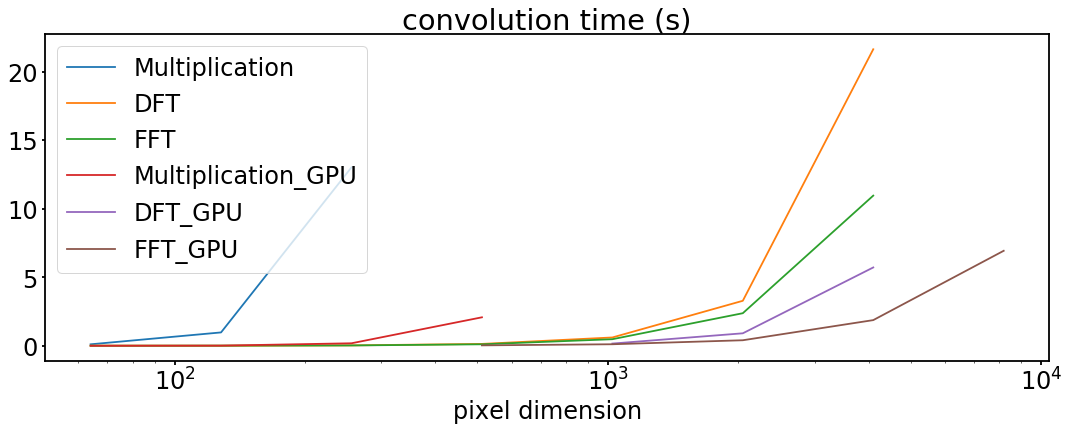

In [19]:
plt.plot(dimensions[:len(Convolve_time)], Convolve_time, label = 'Multiplication')
plt.plot(dimensions, DFT_time, label = 'DFT')
plt.plot(dimensions, FFT_time, label = 'FFT')
plt.plot(list(GPU_Convolve_time.keys()),list(GPU_Convolve_time.values()), label = 'Multiplication_GPU')
plt.plot(list(GPU_DFT_time.keys()),list(GPU_DFT_time.values()), label = 'DFT_GPU')
plt.plot(list(GPU_FFT_time.keys()),list(GPU_FFT_time.values()), label = 'FFT_GPU')
plt.xscale('log')
plt.xlabel('pixel dimension')
plt.title('convolution time (s)')
plt.legend(loc='upper left')

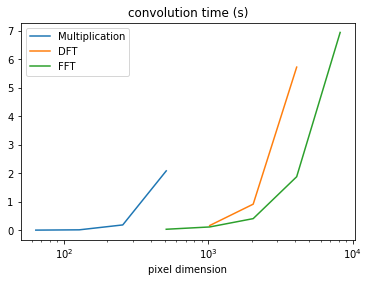

In [ ]:
plt.plot(list(GPU_Convolve_time.keys()),list(GPU_Convolve_time.values()), label = 'Multiplication')
plt.plot(list(GPU_DFT_time.keys()),list(GPU_DFT_time.values()), label = 'DFT')
plt.plot(list(GPU_FFT_time.keys()),list(GPU_FFT_time.values()), label = 'FFT')
plt.plot(list(GPU_Convolve_time.keys()),list(GPU_Convolve_time.values()), label = 'Multiplication')
plt.plot(list(GPU_DFT_time.keys()),list(GPU_DFT_time.values()), label = 'DFT')
plt.plot(list(GPU_FFT_time.keys()),list(GPU_FFT_time.values()), label = 'FFT')
plt.xscale('log')
plt.xlabel('pixel dimension')
plt.title('convolution time (s)')
plt.legend()

In [7]:
dim = 512
# A=np.random.random((dim,dim)).astype('f4')
# B=np.random.random((dim,dim)).astype('f4')
A=np.zeros((dim*2,dim*2)).astype('f4')
B=np.zeros((dim*2,dim*2)).astype('f4')
A[:dim,:dim]=np.indices((dim,dim))[0].astype('f4')
B[:dim,:dim]=np.indices((dim,dim))[0].astype('f4')
C=np.zeros((dim*2,dim*2)).astype('f8')

In [8]:
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=A)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=B)
res_g = cl.Buffer(ctx, mf.READ_WRITE, C.nbytes)
prg.cross_correlate(queue, A.shape, (32,32), a_g, b_g, res_g)
cl.enqueue_copy(queue, C, res_g)
print(C)

[[2.28371990e+10 2.27891517e+10 2.27473958e+10 ... 2.27054301e+10
  2.27486606e+10 2.27938568e+10]
 [2.27702135e+10 2.27233963e+10 2.26804492e+10 ... 2.26390170e+10
  2.26824634e+10 2.27270070e+10]
 [2.27029674e+10 2.26567967e+10 2.26142500e+10 ... 2.25724321e+10
  2.26157445e+10 2.26601577e+10]
 ...
 [2.26359552e+10 2.25839540e+10 2.25499019e+10 ... 2.25058235e+10
  2.25496634e+10 2.25944755e+10]
 [2.27029221e+10 2.26507754e+10 2.26166183e+10 ... 2.25724072e+10
  2.26163771e+10 2.26613213e+10]
 [2.27698900e+10 2.27175978e+10 2.26833358e+10 ... 2.26389918e+10
  2.26830918e+10 2.27281682e+10]]


In [335]:
(A*B).mean() * A.size

254.45062255859375

In [419]:
from scipy.signal import convolve2d, correlate2d
correlate2d(A,np.fft.fftshift(B),mode='same', boundary = 'wrap')

array([[5249664., 5166336., 5083008., ..., 5166336., 5249664., 5332992.],
       [5122719., 5041406., 4960093., ..., 5041406., 5122719., 5204032.],
       [4995900., 4916600., 4837300., ..., 4916600., 4995900., 5075200.],
       ...,
       [5122719., 5041406., 4960093., ..., 5041406., 5122719., 5204032.],
       [5249664., 5166336., 5083008., ..., 5166336., 5249664., 5332992.],
       [5376672., 5291328., 5205984., ..., 5291328., 5376672., 5462016.]],
      dtype=float32)

In [ ]:
dimension = 4096
# ind_np = np.indices((dimension,dimension),dtype = 'c8')
a_np = np.random.random((dimension,dimension)).astype('c8')
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
res_g = cl.Buffer(ctx, mf.READ_WRITE, a_np.nbytes)
tmp = cl.Buffer(ctx, mf.READ_WRITE, a_np.nbytes)
# knl = prg.FFT_rearrange
prg.FFT_rearrange(queue, a_np.shape, None, a_g, res_g)
prg.FFT_under_512(queue, a_np.shape, (1,512), res_g)
i = np.array(10,dtype='i4')
while (1<<i) <= dimension:
    res_g, tmp = tmp, res_g
    print(i)
    prg.FFT_over_512(queue, a_np.shape, None, tmp, res_g, i)
    i += 1
res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

print(res_np)
print(res_np - np.fft.fft(a_np))
print(np.linalg.norm(res_np - np.fft.fft(a_np)))

10
11
12
[[2055.6172   +0.j         -24.389812-15.092072j   -10.494537 +2.5215156j
  ...    4.599781 +6.744068j   -10.494541 -2.5215135j
   -24.389801+15.092085j ]
 [2055.6172   +0.j         -24.389812-15.092072j   -10.494537 +2.5215156j
  ...    4.599781 +6.744068j   -10.494541 -2.5215135j
   -24.389801+15.092085j ]
 [2055.6172   +0.j         -24.389812-15.092072j   -10.494537 +2.5215156j
  ...    4.599781 +6.744068j   -10.494541 -2.5215135j
   -24.389801+15.092085j ]
 ...
 [2055.6172   +0.j         -24.389812-15.092072j   -10.494537 +2.5215156j
  ...    4.599781 +6.744068j   -10.494541 -2.5215135j
   -24.389801+15.092085j ]
 [2055.6172   +0.j         -24.389812-15.092072j   -10.494537 +2.5215156j
  ...    4.599781 +6.744068j   -10.494541 -2.5215135j
   -24.389801+15.092085j ]
 [2055.6172   +0.j         -24.389812-15.092072j   -10.494537 +2.5215156j
  ...    4.599781 +6.744068j   -10.494541 -2.5215135j
   -24.389801+15.092085j ]]
[[-7.61536312e-05+0.00000000e+00j  2.71615903e-08+1.321

In [252]:
(res_np - np.fft.fft(a_np))[0,:5]

array([-7.61536312e-05+0.00000000e+00j,  2.71615903e-08+1.32130968e-06j,
        2.00023118e-06+2.75857553e-06j, -1.53485939e-06-1.18180101e-06j,
        1.49343737e-07+9.51850613e-07j])

In [257]:
C.shape

(10, 10)

In [254]:
from scipy.signal import convolve

In [260]:
for i in range(10):
    C[i,:] = convolve(A[i,:],B[i,:],mode='valid')
for i in range(10):
    C[:,i] = convolve(A[:,i],B[:,i],mode='valid')

In [262]:
C-convolve(A,B,mode='valid')

array([[-23.88360946, -22.99046095, -23.22177725, -23.93576272,
        -23.86824183, -23.45232214, -23.2627074 , -23.92577286,
        -22.84184517, -23.47553063],
       [-23.88360946, -22.99046095, -23.22177725, -23.93576272,
        -23.86824183, -23.45232214, -23.2627074 , -23.92577286,
        -22.84184517, -23.47553063],
       [-23.88360946, -22.99046095, -23.22177725, -23.93576272,
        -23.86824183, -23.45232214, -23.2627074 , -23.92577286,
        -22.84184517, -23.47553063],
       [-23.88360946, -22.99046095, -23.22177725, -23.93576272,
        -23.86824183, -23.45232214, -23.2627074 , -23.92577286,
        -22.84184517, -23.47553063],
       [-23.88360946, -22.99046095, -23.22177725, -23.93576272,
        -23.86824183, -23.45232214, -23.2627074 , -23.92577286,
        -22.84184517, -23.47553063],
       [-23.88360946, -22.99046095, -23.22177725, -23.93576272,
        -23.86824183, -23.45232214, -23.2627074 , -23.92577286,
        -22.84184517, -23.47553063],
       [-2

In [250]:
res_np[0,:5]

array([2055.6172   +0.j       ,  -24.389812-15.092072j ,
        -10.494537 +2.5215156j,    4.599781 -6.744069j ,
        -14.798006 -4.0356297j], dtype=complex64)

In [251]:
np.fft.fft(a_np)[0,:5]

array([2055.61726365 +0.j        ,  -24.3898125 -15.09207285j,
        -10.49453935 +2.52151285j,    4.59978257 -6.74406792j,
        -14.79800621 -4.0356307j ])

In [231]:
np.array(10).shape

()

In [233]:
res_np[0,-10:]

array([ 267012.44-2048.0645j,  296681.5 -2048.1084j,
        333767.94-2048.079j ,  381450.2 -2048.1038j,
        445026.38-2048.1667j,  534032.75-2048.1465j,
        667542.1 -2048.1814j,  890057.5 -2048.3665j,
       1335087.4 -2048.4153j, 2670176.2 -2048.9414j], dtype=complex64)

In [235]:
res_np[0,:10]

array([       0.  +8.3865600e+06j, -2670175.8 -2.0478828e+03j,
       -1335087.1 -2.0479413e+03j,  -890057.4 -2.0480000e+03j,
        -667542.  -2.0479705e+03j,  -534032.6 -2.0478972e+03j,
        -445026.3 -2.0480000e+03j,  -381450.  -2.0479280e+03j,
        -333767.88-2.0479851e+03j,  -296681.62-2.0480061e+03j],
      dtype=complex64)

In [ ]:
res_np[0,:10]

array([0.  +0.j, 0.+256.j, 0.+128.j, 0.+384.j, 0. +64.j, 0.+320.j,
       0.+192.j, 0.+448.j, 0. +32.j, 0.+288.j], dtype=complex64)

In [185]:
ind_np[0,:10]

array([0.+0.j, 0.+1.j, 0.+2.j, 0.+3.j, 0.+4.j, 0.+5.j, 0.+6.j, 0.+7.j,
       0.+8.j, 0.+9.j], dtype=complex64)

In [178]:
ind_np[0].sum()

130816j

In [234]:
np.fft.fft(ind_np[0,:])[:10]

array([       0.        +8.38656e+06j, -2670176.33412164-2.04800e+03j,
       -1335087.3816625 -2.04800e+03j,  -890057.3817766 -2.04800e+03j,
        -667542.12003369-2.04800e+03j,  -534032.75354764-2.04800e+03j,
        -445026.33468965-2.04800e+03j,  -381450.17161873-2.04800e+03j,
        -333767.91841434-2.04800e+03j,  -296681.60512054-2.04800e+03j])

In [201]:
np.fft.fft(ind_np[0,:])[-10:]

array([ 4166.91403774-256.j,  4631.010364  -256.j,  5210.999712  -256.j,
        5956.55055798-256.j,  6950.44369042-256.j,  8341.68452221-256.j,
       10428.28387125-256.j, 13905.60030215-256.j, 20859.70949288-256.j,
       41720.98980179-256.j])

In [194]:
res_np[0,:10]

array([0.  +0.j, 0.+256.j, 0.+128.j, 0.+384.j, 0. +64.j, 0.+320.j,
       0.+192.j, 0.+448.j, 0. +32.j, 0.+288.j], dtype=complex64)

In [165]:
res_np.imag

array([[  0., 256., 128., ..., 383., 255., 511.],
       [  0., 256., 128., ..., 383., 255., 511.],
       [  0., 256., 128., ..., 383., 255., 511.],
       ...,
       [  0., 256., 128., ..., 383., 255., 511.],
       [  0., 256., 128., ..., 383., 255., 511.],
       [  0., 256., 128., ..., 383., 255., 511.]], dtype=float32)

In [151]:
bin(384)

'0b110000000'

In [105]:
a_np

array([0.27541804+0.j, 0.6056611 +0.j, 0.5837389 +0.j, ...,
       0.4348739 +0.j, 0.05950231+0.j, 0.07527219+0.j], dtype=complex64)

In [100]:
(0.9238795-0.38268346j )**(3)

(0.38268330477574136-0.9238795221669254j)

In [132]:
np.fft.fft(a_np)

array([1038.50786119 +0.j        ,   -1.97613433-13.11922541j,
          7.19724864 -2.79116965j, ...,    6.67672473 +2.26078355j,
          7.19724864 +2.79116965j,   -1.97613433+13.11922541j])

In [4]:
ctx = cl.Context(devices=cl.get_platforms()[0].get_devices()[:1])
queue = cl.CommandQueue(ctx)
mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
# b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

#complex64 x+yi
#float2 x,y
local_size = (32,32)
prg = cl.Program(ctx, f"""
#define TPB_X {local_size[0]}
#define TPB_Y {local_size[1]}
"""+"""
inline float2 compmul(float2 a, float2 b){
  return (float2)(a.x*b.x - a.y*b.y, a.x*b.y + a.y*b.x);
}
__kernel void matmul(__global const float2 *A, __global const float2 *B, __global const float2 *C){
  const int Ay = get_global_id(0);
  const int Bx = get_global_id(1);
  const int ty = get_local_id(0);
  const int tx = get_local_id(1);
  private float2 sum = (0, 0);
  local float2 A_block[TPB_X * TPB_Y];
  local float2 B_block[TPB_X * TPB_Y];
  A_block[TPB_X * ty + tx] = A[Ay, tx];
  B_block[TPB_X * tx + ty] = B[ty, Bx];
  barrier(CLK_GLOBAL_MEM_FENCE) // load shared memory and synchronize
  for(int y=0;y<ty;y++)for(int x=0;x<tx;x++)sum+=compmul(A_block[ty])


}


__kernel void sum(
    __global const float *a_g, __global const float *b_g, __global float *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

RuntimeError: clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE

Build on <pyopencl.Device 'GeForce RTX 2080 SUPER' on 'NVIDIA CUDA' at 0x2333222f760>:

<kernel>:13:25: warning: expression result unused
  private float2 sum = (0, 0);
                        ^
<kernel>:16:32: warning: expression result unused
  A_block[TPB_X * ty + tx] = A[Ay, tx];
                               ^~
<kernel>:17:32: warning: expression result unused
  B_block[TPB_X * tx + ty] = B[ty, Bx];
                               ^~
<kernel>:18:32: error: expected ';' after expression
  barrier(CLK_GLOBAL_MEM_FENCE) // load shared memory and synchronize
                               ^
                               ;
<kernel>:19:69: error: too few arguments to function call, expected 2, have 1
  for(int y=0;y<ty;y++)for(int x=0;x<tx;x++)sum+=compmul(A_block[ty])
                                                 ~~~~~~~            ^
<kernel>:5:1: note: 'compmul' declared here
inline float2 compmul(float2 a, float2 b){
^

(options: -I c:\Users\Faki\Anaconda3\lib\site-packages\pyopencl\cl)
(source saved as C:\Users\Faki\AppData\Local\Temp\tmpyd90jbcp.cl)

In [5]:
a_np = np.random.rand(50000).astype('c8')*(1+1j)
b_np = np.random.rand(50000).astype('c8')

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
inline float2 compmul(float2 a, float2 b){
  return (float2)(a.x*b.x - a.y*b.y, a.x*b.y + a.y*b.x);
}
__kernel void sum(
    __global const float2 *a_g, __global const float2 *b_g, __global float2 *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = compmul(a_g[gid], b_g[gid]);
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np * b_np))
print(np.linalg.norm(res_np - (a_np * b_np)))
assert np.allclose(res_np, a_np * b_np)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
0.0


In [54]:
a_np

array([0.+0.8155622j , 0.+0.5304822j , 0.+0.5484743j , ...,
       0.+0.2845743j , 0.+0.6207339j , 0.+0.00686155j], dtype=complex64)

In [55]:
res_np

array([0.8155622 +0.8155622j , 0.5304822 +0.5304822j ,
       0.5484743 +0.5484743j , ..., 0.2845743 +0.2845743j ,
       0.6207339 +0.6207339j , 0.00686155+0.00686155j], dtype=complex64)

In [ ]:
a_np = np.random.rand(50000).astype(np.float32)
b_np = np.random.rand(50000).astype(np.float32)

ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
a_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=a_np)
b_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=b_np)

prg = cl.Program(ctx, """
__kernel void sum(
    __global const float *a_g, __global const float *b_g, __global float *res_g)
{
  int gid = get_global_id(0);
  res_g[gid] = a_g[gid] + b_g[gid];
}
""").build()

res_g = cl.Buffer(ctx, mf.WRITE_ONLY, a_np.nbytes)
knl = prg.sum  # Use this Kernel object for repeated calls
knl(queue, a_np.shape, None, a_g, b_g, res_g)

res_np = np.empty_like(a_np)
cl.enqueue_copy(queue, res_np, res_g)

# Check on CPU with Numpy:
print(res_np - (a_np + b_np))
print(np.linalg.norm(res_np - (a_np + b_np)))
assert np.allclose(res_np, a_np + b_np)

[0. 0. 0. ... 0. 0. 0.]
0.0


In [21]:
cl.Context(devices=cl.get_platforms()[0].get_devices()[:1])

<pyopencl.Context at 0x204b84d59f0 on <pyopencl.Device 'GeForce RTX 2080 SUPER' on 'NVIDIA CUDA' at 0x204a630aa20>>

In [13]:
cl.get_platforms()[0].get_devices()

[<pyopencl.Device 'GeForce RTX 2080 SUPER' on 'NVIDIA CUDA' at 0x204a630aa20>,
 <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x204a630aa70>]

In [12]:
cl.tools.get_test_platforms_and_devices()

[(<pyopencl.Platform 'NVIDIA CUDA' at 0x204a630ac00>,
  [<pyopencl.Device 'GeForce RTX 2080 SUPER' on 'NVIDIA CUDA' at 0x204a630aa20>,
   <pyopencl.Device 'GeForce GTX 1050 Ti' on 'NVIDIA CUDA' at 0x204a630aa70>])]

In [8]:
prg

In [198]:
f2 = np.fft.fft2
f2(f2(f2(f2(x))/256)/256).real

array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.],
       [ 16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,
         27.,  28.,  29.,  30.,  31.],
       [ 32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,
         43.,  44.,  45.,  46.,  47.],
       [ 48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
         59.,  60.,  61.,  62.,  63.],
       [ 64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,
         75.,  76.,  77.,  78.,  79.],
       [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
         91.,  92.,  93.,  94.,  95.],
       [ 96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
        107., 108., 109., 110., 111.],
       [112., 113., 114., 115., 116., 117., 118., 119., 120., 121., 122.,
        123., 124., 125., 126., 127.],
       [128., 129., 130., 131., 132., 133., 134., 135., 136., 137., 138.,
        139., 140., 14

In [197]:
np.fft.fft2(np.fft.fft2(x)/256).real

array([[  0.,  15.,  14.,  13.,  12.,  11.,  10.,   9.,   8.,   7.,   6.,
          5.,   4.,   3.,   2.,   1.],
       [240., 255., 254., 253., 252., 251., 250., 249., 248., 247., 246.,
        245., 244., 243., 242., 241.],
       [224., 239., 238., 237., 236., 235., 234., 233., 232., 231., 230.,
        229., 228., 227., 226., 225.],
       [208., 223., 222., 221., 220., 219., 218., 217., 216., 215., 214.,
        213., 212., 211., 210., 209.],
       [192., 207., 206., 205., 204., 203., 202., 201., 200., 199., 198.,
        197., 196., 195., 194., 193.],
       [176., 191., 190., 189., 188., 187., 186., 185., 184., 183., 182.,
        181., 180., 179., 178., 177.],
       [160., 175., 174., 173., 172., 171., 170., 169., 168., 167., 166.,
        165., 164., 163., 162., 161.],
       [144., 159., 158., 157., 156., 155., 154., 153., 152., 151., 150.,
        149., 148., 147., 146., 145.],
       [128., 143., 142., 141., 140., 139., 138., 137., 136., 135., 134.,
        133., 132., 13

In [124]:
%timeit FFT(im.astype('c8'))

3.51 ms ± 697 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [125]:
%timeit DFT(im.astype('c8'))

2.71 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [143]:
im = np.random.random((4096,4096))

In [155]:
%timeit FFT_2D(im.astype('c8'))

3.16 s ± 120 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [145]:
%timeit DFT_2D(im.astype('c8'))

6.79 s ± 634 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
%timeit np.fft.fft2(im.astype('c8'))

1.05 s ± 107 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [85]:
np.indices((100,), dtype = 'complex64')

array([[ 0.+0.j,  1.+0.j,  2.+0.j,  3.+0.j,  4.+0.j,  5.+0.j,  6.+0.j,
         7.+0.j,  8.+0.j,  9.+0.j, 10.+0.j, 11.+0.j, 12.+0.j, 13.+0.j,
        14.+0.j, 15.+0.j, 16.+0.j, 17.+0.j, 18.+0.j, 19.+0.j, 20.+0.j,
        21.+0.j, 22.+0.j, 23.+0.j, 24.+0.j, 25.+0.j, 26.+0.j, 27.+0.j,
        28.+0.j, 29.+0.j, 30.+0.j, 31.+0.j, 32.+0.j, 33.+0.j, 34.+0.j,
        35.+0.j, 36.+0.j, 37.+0.j, 38.+0.j, 39.+0.j, 40.+0.j, 41.+0.j,
        42.+0.j, 43.+0.j, 44.+0.j, 45.+0.j, 46.+0.j, 47.+0.j, 48.+0.j,
        49.+0.j, 50.+0.j, 51.+0.j, 52.+0.j, 53.+0.j, 54.+0.j, 55.+0.j,
        56.+0.j, 57.+0.j, 58.+0.j, 59.+0.j, 60.+0.j, 61.+0.j, 62.+0.j,
        63.+0.j, 64.+0.j, 65.+0.j, 66.+0.j, 67.+0.j, 68.+0.j, 69.+0.j,
        70.+0.j, 71.+0.j, 72.+0.j, 73.+0.j, 74.+0.j, 75.+0.j, 76.+0.j,
        77.+0.j, 78.+0.j, 79.+0.j, 80.+0.j, 81.+0.j, 82.+0.j, 83.+0.j,
        84.+0.j, 85.+0.j, 86.+0.j, 87.+0.j, 88.+0.j, 89.+0.j, 90.+0.j,
        91.+0.j, 92.+0.j, 93.+0.j, 94.+0.j, 95.+0.j, 96.+0.j, 97.+0.j,
      

In [81]:
(np.abs(DFT_2D(im.astype('complex64')) - np.fft.fft2(im.astype('complex64'))).max())

0.024595019276879036

In [72]:
DFT(im.astype('complex64'))

array([[51.722347  +0.j        , 51.3077    +0.j        ,
        52.734257  +0.j        , ..., 54.791195  +0.j        ,
        46.506958  +0.j        , 48.2907    +0.j        ],
       [-0.43510166-1.8598697j ,  2.1568806 -0.14518023j,
        -2.3426147 -1.7194556j , ...,  0.3152113 +2.969859j  ,
        -0.24472259-3.7790878j ,  1.5979205 +2.8453937j ],
       [-1.1932945 +0.9424612j , -2.6745787 +0.49207264j,
         2.0966783 +4.66387j   , ...,  1.9392802 -0.46233603j,
        -1.9460723 -2.4543548j , -1.5759813 -0.93852043j],
       ...,
       [-1.2924961 -2.838823j  , -0.32342926-5.3968935j ,
        -1.4737737 -0.9790594j , ...,  0.25564033-3.062184j  ,
        -1.75585   +2.7491593j ,  0.12866984+2.1279614j ],
       [-1.1934584 -0.9424772j , -2.6747415 -0.49207693j,
         2.096478  -4.6639304j , ...,  1.9391296 +0.46228737j,
        -1.9461335 +2.454408j  , -1.576162  +0.93857837j],
       [-0.43532386+1.8598753j ,  2.156621  +0.14509048j,
        -2.3428648 +1.7194804j

In [13]:
np.indices((100, 100),dtype = 'complex64') /100

array([[[0.        +0.j, 0.        +0.j, 0.        +0.j, ...,
         0.        +0.j, 0.        +0.j, 0.        +0.j],
        [0.01      +0.j, 0.01      +0.j, 0.01      +0.j, ...,
         0.01      +0.j, 0.01      +0.j, 0.01      +0.j],
        [0.02      +0.j, 0.02      +0.j, 0.02      +0.j, ...,
         0.02      +0.j, 0.02      +0.j, 0.02      +0.j],
        ...,
        [0.96999997+0.j, 0.96999997+0.j, 0.96999997+0.j, ...,
         0.96999997+0.j, 0.96999997+0.j, 0.96999997+0.j],
        [0.97999996+0.j, 0.97999996+0.j, 0.97999996+0.j, ...,
         0.97999996+0.j, 0.97999996+0.j, 0.97999996+0.j],
        [0.98999995+0.j, 0.98999995+0.j, 0.98999995+0.j, ...,
         0.98999995+0.j, 0.98999995+0.j, 0.98999995+0.j]],

       [[0.        +0.j, 0.01      +0.j, 0.02      +0.j, ...,
         0.96999997+0.j, 0.97999996+0.j, 0.98999995+0.j],
        [0.        +0.j, 0.01      +0.j, 0.02      +0.j, ...,
         0.96999997+0.j, 0.97999996+0.j, 0.98999995+0.j],
        [0.        +0.j, 

In [101]:
im = np.random.random((128,128))

In [7]:
DFT(im)

array([[3.5481378e-09+4.5592647e-41j, 3.5481378e-09+4.5592647e-41j,
        5.4710925e-37+0.0000000e+00j, ..., 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j],
       [0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, ..., 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j],
       [0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, ..., 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j],
       ...,
       [0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+2.3694275e-38j, ..., 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j],
       [0.0000000e+00+0.0000000e+00j, 0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j, ..., 2.3694278e-38+2.3694278e-38j,
       